# Excess deaths due to COVID-19

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2020-01-01")
df.head()

,temp,deaths,year,month,t,pre
date,,,,,,
2006-01-01,3.8,49124,2006,1,0,True
2006-02-01,3.4,42664,2006,2,1,True
2006-03-01,3.9,49207,2006,3,2,True
2006-04-01,7.4,40645,2006,4,3,True
2006-05-01,10.7,42425,2006,5,4,True


The columns are:

* `date` + `year`: self explanatory
* `month`: month, numerically encoded. Needs to be treated as a categorical variable
* `temp`: average UK temperature (Celcius)
* `t`: time
* `pre`: boolean flag indicating pre or post intervention

## Run the analysis

In this example we are going to standardize the data. So we have to be careful in how we interpret the inferred regression coefficients, and the posterior predictions will be in this standardized space.

<div class="alert alert-info">

Note:

The `random_seed` keyword argument for the PyMC sampler is not neccessary. We use it here so that the results are reproducible.

</div>

In [4]:
result = cp.pymc_experiments.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="standardize(deaths) ~ 0 + standardize(t) + C(month) + standardize(temp)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


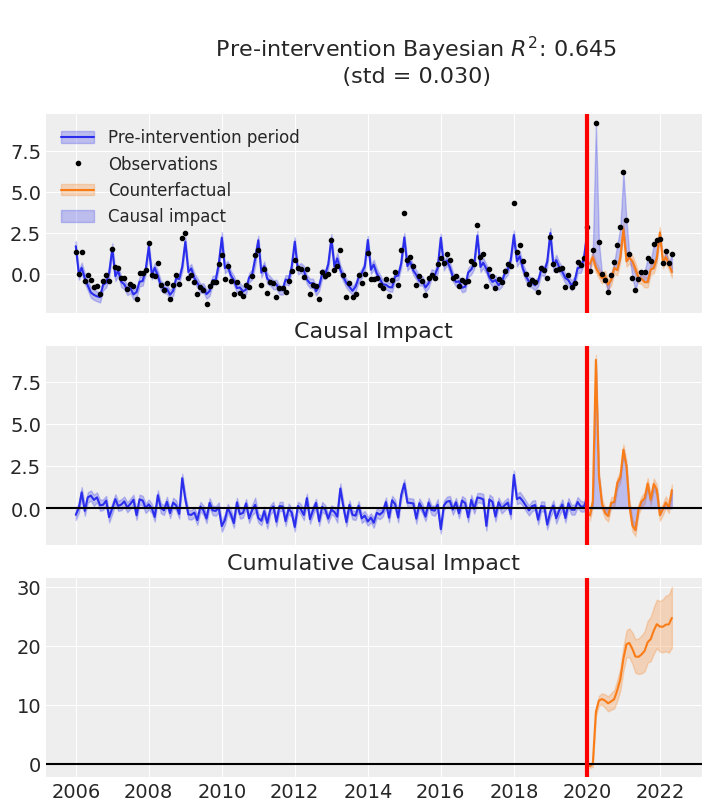

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

============================Interrupted Time Series=============================
Formula: standardize(deaths) ~ 0 + standardize(t) + C(month) + standardize(temp)
Model coefficients:
C(month)[1]                   1.57, 94% HDI [1.14, 2.01]
C(month)[2]                   -0.20, 94% HDI [-0.64, 0.21]
C(month)[3]                   0.25, 94% HDI [-0.11, 0.62]
C(month)[4]                   -0.04, 94% HDI [-0.33, 0.24]
C(month)[5]                   -0.16, 94% HDI [-0.46, 0.13]
C(month)[6]                   -0.23, 94% HDI [-0.62, 0.17]
C(month)[7]                   -0.05, 94% HDI [-0.54, 0.46]
C(month)[8]                   -0.43, 94% HDI [-0.88, 0.04]
C(month)[9]                   -0.45, 94% HDI [-0.82, -0.09]
C(month)[10]                  -0.07, 94% HDI [-0.35, 0.21]
C(month)[11]                  -0.37, 94% HDI [-0.69, -0.05]
C(month)[12]                  0.06, 94% HDI [-0.35, 0.46]
standardize(t)                0.24, 94% HDI [0.15, 0.32]
standardize(temp)             -0.43, 94% HDI [-0.71, -0